# Solar Weather Lab: Predicting Sunspot Activity

## Introduction
Have you ever wondered how the Sun's activity influences space weather and even life on Earth? Sunspots — dark, cooler regions on the Sun’s surface - are closely tied to solar storms that can disrupt satellites, GPS, and even power grids. Understanding and predicting sunspot activity is crucial for space weather forecasting.

In this lab, you’ll experiment with sequence modeling using some of the techniques we have covered in class to predict sunspot numbers. We'll use real NASA data and train various sequence models, including Recurrent Neural Networks (RNNs), Gated Recurrent Units (GRUs), Long Short-Term Memory (LSTM) networks, and the state-of-the-art Mamba model. You will fine-tune these models and optimize hyperparameters to improve RMSE accuracy. By the end, you’ll gain hands-on experience with time series forecasting and sequence learning, all while unraveling the mysteries of our star!

## Objectives
- Fetch and preprocess real-world NASA Sunspot data.
- Apply sequence modeling techniques for time series forecasting.
- Implement and train RNN, GRU, LSTM, and Mamba models using PyTorch.
- Tune hyperparameters and optimize models for improved RMSE accuracy.
- Evaluate model performance and visualize predictions.

## Prerequisites
Before starting, ensure you have:
- Basic knowledge of Python and PyTorch.
- Familiarity with neural networks and sequence modeling (RNNs, GRUs, LSTMs, Mamba).
- Experience with data preprocessing and time series analysis.

## Dataset
We will use NASA’s **Sunspot & Solar Weather Data**, fetched from:
[NOAA Solar Cycle Sunspots JSON](https://services.swpc.noaa.gov/json/solar-cycle/sunspots.json)
This dataset includes historical sunspot counts and solar flux data, essential for understanding solar activity cycles.

---

## Lab Steps

### Preprocessing
   - Retrieve the NASA’s **Sunspot & Solar Weather Data**.  
   - Normalize the data and handle missing values (minmax scaler is provided).  
   - Convert the dataset into sequences (48 past time steps are provided)


### Implement Sequence Models

You will implement and compare the following models:

- **Simple RNN**
 - Implement a single-layer RNN to process seismic time-series data.
 - Train and evaluate performance.

- **Long Short-Term Memory (LSTM) - this is provided**
 - Implement an LSTM-based model to capture long-range dependencies.
 - Compare results with the simple RNN model.

- **Gated Recurrent Unit (GRU)**
 - Implement a GRU model and analyze its efficiency in training and generalization.


### Evaluation and insights
- **Compare Model Performance**  
   - Train all models using the same dataset split.  
   - Evaluate using RMSE.
   - Evaluate performance in terms of training time vs inference time.
   - Visualize loss curves and performance metrics.
   - Compare how different architectures handle sequence modeling.
   - Discuss challenges such as overfitting and vanishing gradients.


---

### **Deliverables**
- Notebook with code and explanations.
- Report summarizing findings and insights, include visualizations comparing model predictions.

---



In [2]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.metrics import mean_squared_error, r2_score


class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        return self.fc(rnn_out[:, -1, :])

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        return self.fc(gru_out[:, -1, :])


#Sequence Data Preparation
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Combined loss function
def combined_loss(predictions, targets, alpha=.7):
    mse = torch.nn.functional.mse_loss(predictions, targets)
    rmse = torch.sqrt(mse)
    return alpha * mse + (1 - alpha) * rmse

#Training Loop
def train_model(model, train_loader, val_loader, epochs=10, alpha=.7):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []

    start_time = time.time()
    model.train()

    for epoch in range(epochs):
        total_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = combined_loss(predictions, y_batch, alpha)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_preds = model(X_val)
                val_loss += combined_loss(val_preds, y_val, alpha).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    return train_losses, val_losses, training_time

# Testing loop
def evaluate(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    inference_start_time = time.time()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch).numpy()
            predictions.extend(preds)
            actuals.extend(y_batch.cpu().numpy())
    inference_time = time.time() - inference_start_time
    print(f"Inference time: {inference_time:.4f} seconds")

    rmse = np.sqrt(mean_squared_error(np.array(actuals), np.array(predictions)))
    r2 = r2_score(np.array(actuals), np.array(predictions))
    print(f"RMSE: {rmse:.4f}, R² Score: {r2:.4f}")
    return np.array(predictions), np.array(actuals), inference_time, rmse, r2


def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, 0], label="Actual", linestyle="dashed")
    plt.plot(y_pred[:, 0], label="Predicted")
    plt.legend()
    plt.title(title)
    plt.show()

def plot_loss(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss (Combined MSE + RMSE)")
    plt.plot(val_losses, label="Validation Loss", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Training and Validation Loss")
    plt.legend()
    plt.show()


url = "https://services.swpc.noaa.gov/json/solar-cycle/sunspots.json"
response = requests.get(url)

if response.status_code == 200:
    raw_data = response.json()
else:
    print(f"Error {response.status_code}: Unable to fetch data")
    raw_data = []

# Preprocessing
df = pd.DataFrame(raw_data)
print(df.head())
df['time-tag'] = pd.to_datetime(df['time-tag'])
df.set_index('time-tag', inplace=True)
df = df[['ssn']]  # Selecting relevant features


# Split data into training, validation and testing sets
train_size = int(len(df) * 0.7)  # 70% for training
val_size = int(len(df) * 0.1)    # 10% for validation
test_size = len(df) - train_size - val_size  # 20% for testing

df_train = df.iloc[:train_size]
df_val = df.iloc[train_size:train_size+val_size]
df_test = df.iloc[train_size+val_size:]

# Normalize data
scaler = MinMaxScaler()
df_train[df_train.columns] = scaler.fit_transform(df_train[df_train.columns])
df_val[df_val.columns] = scaler.transform(df_val[df_val.columns])
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns])

sequence_length = 48  # Using past 48 timesteps
data_train_array = df_train.values
data_test_array = df_test.values
data_val_array = df_val.values

X_train, y_train = create_sequences(data_train_array, sequence_length)
X_test, y_test = create_sequences(data_test_array, sequence_length)
X_val, y_val = create_sequences(data_val_array, sequence_length)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)





  time-tag    ssn
0  1749-01   96.7
1  1749-02  104.3
2  1749-03  116.7
3  1749-04   92.8
4  1749-05  141.7


<ipython-input-2-7318aa179377>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[df_train.columns] = scaler.fit_transform(df_train[df_train.columns])
<ipython-input-2-7318aa179377>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[df_val.columns] = scaler.transform(df_val[df_val.columns])
<ipython-input-2-7318aa179377>:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Epoch 1/10, Train Loss: 0.014881, Val Loss: 0.008271
Epoch 2/10, Train Loss: 0.005236, Val Loss: 0.006827
Epoch 3/10, Train Loss: 0.004991, Val Loss: 0.006672
Epoch 4/10, Train Loss: 0.004765, Val Loss: 0.005700
Epoch 5/10, Train Loss: 0.004567, Val Loss: 0.005303
Epoch 6/10, Train Loss: 0.004323, Val Loss: 0.005069
Epoch 7/10, Train Loss: 0.004178, Val Loss: 0.004695
Epoch 8/10, Train Loss: 0.004109, Val Loss: 0.004686
Epoch 9/10, Train Loss: 0.004152, Val Loss: 0.004476
Epoch 10/10, Train Loss: 0.004084, Val Loss: 0.004480
Training time: 35.20 seconds
Inference time: 0.1318 seconds
RMSE: 0.0566, R² Score: 0.8974


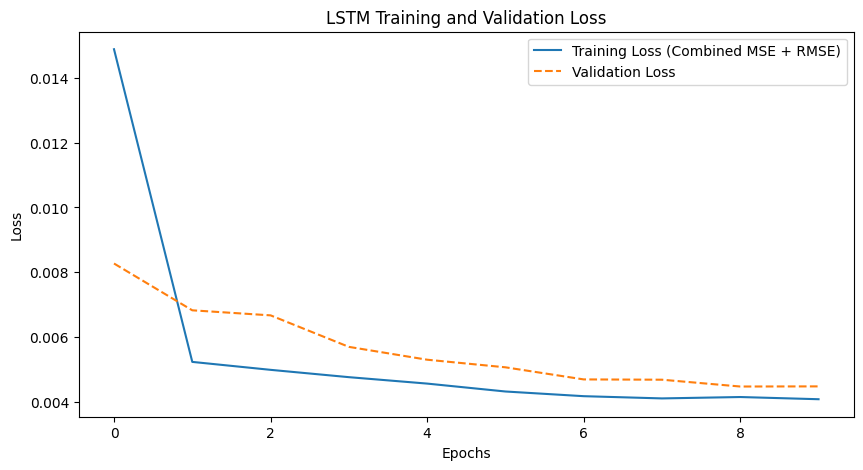

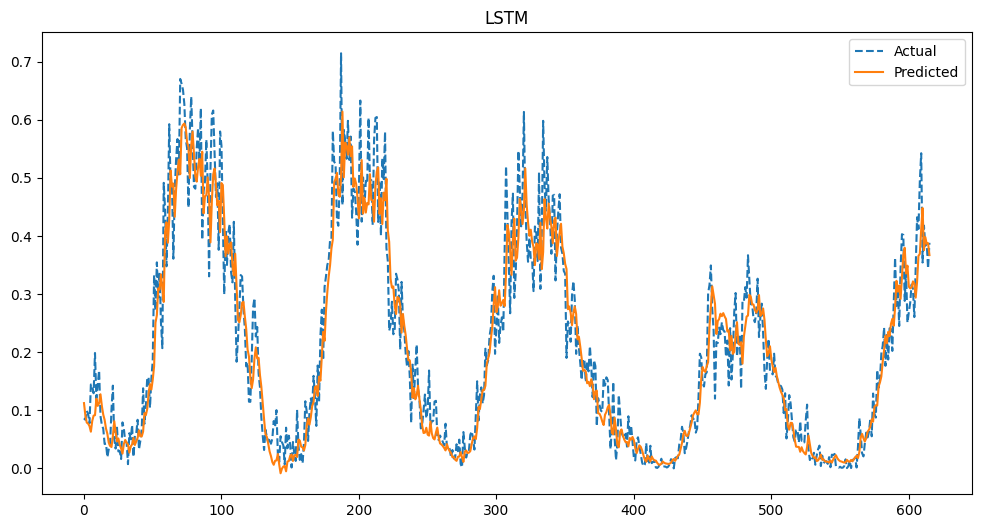

In [3]:
model = LSTMModel(input_dim=df.shape[1], hidden_dim=128, output_dim=df.shape[1])
train_losses, val_losses, time_lstm = train_model(model, train_loader, val_loader, epochs=10)
y_pred, y_true, inf_time, rmse, r2 = evaluate(model, test_loader)
plot_loss(train_losses, val_losses, "LSTM")
plot_results(y_true, y_pred, "LSTM")

Epoch 1/10, Train Loss: 0.018247, Val Loss: 0.007285
Epoch 2/10, Train Loss: 0.004688, Val Loss: 0.006694
Epoch 3/10, Train Loss: 0.004588, Val Loss: 0.007003
Epoch 4/10, Train Loss: 0.004595, Val Loss: 0.005459
Epoch 5/10, Train Loss: 0.004275, Val Loss: 0.005710
Epoch 6/10, Train Loss: 0.004300, Val Loss: 0.004891
Epoch 7/10, Train Loss: 0.004400, Val Loss: 0.005800
Epoch 8/10, Train Loss: 0.004346, Val Loss: 0.004944
Epoch 9/10, Train Loss: 0.004306, Val Loss: 0.005334
Epoch 10/10, Train Loss: 0.004232, Val Loss: 0.004952
Training time: 12.87 seconds
Inference time: 0.0692 seconds
RMSE: 0.0578, R² Score: 0.8931


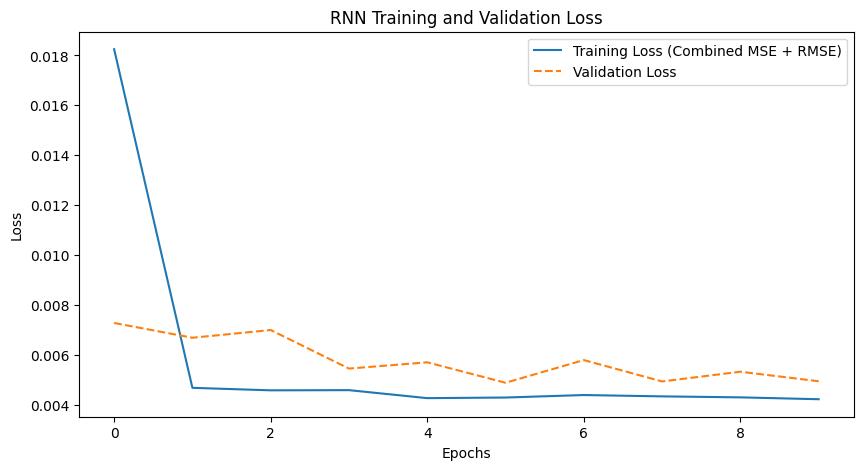

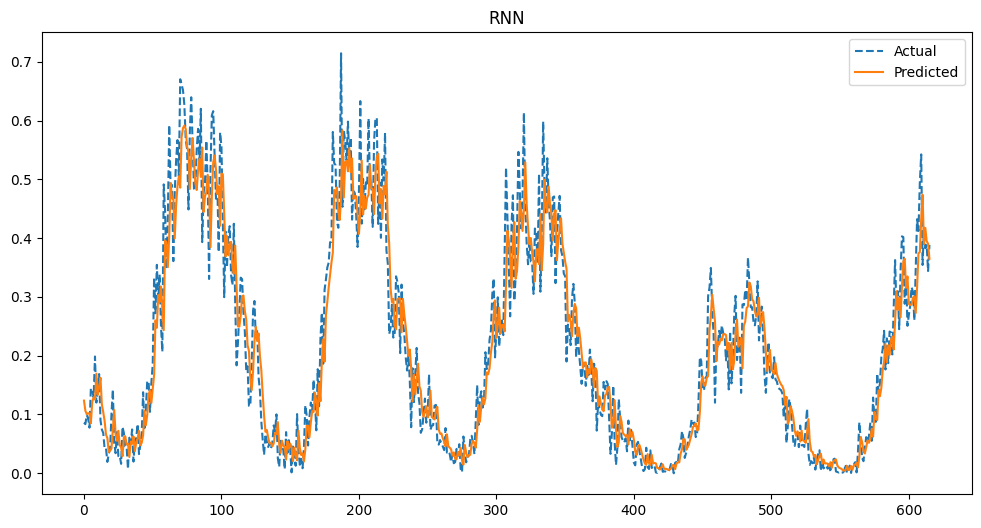

In [4]:
model = RNNModel(input_dim=df.shape[1], hidden_dim=64, output_dim=df.shape[1])
train_losses, val_losses, time_rnn = train_model(model, train_loader, val_loader, epochs=10)
y_pred, y_true, inf_time, rmse, r2 = evaluate(model, test_loader)
plot_loss(train_losses, val_losses, "RNN")
plot_results(y_true, y_pred, "RNN")

Epoch 1/10, Train Loss: 0.020862, Val Loss: 0.008329
Epoch 2/10, Train Loss: 0.005090, Val Loss: 0.006367
Epoch 3/10, Train Loss: 0.004712, Val Loss: 0.006041
Epoch 4/10, Train Loss: 0.004396, Val Loss: 0.005304
Epoch 5/10, Train Loss: 0.004338, Val Loss: 0.007570
Epoch 6/10, Train Loss: 0.004349, Val Loss: 0.004958
Epoch 7/10, Train Loss: 0.004138, Val Loss: 0.004893
Epoch 8/10, Train Loss: 0.004189, Val Loss: 0.005390
Epoch 9/10, Train Loss: 0.004274, Val Loss: 0.005131
Epoch 10/10, Train Loss: 0.004030, Val Loss: 0.004764
Training time: 22.44 seconds
Inference time: 0.1194 seconds
RMSE: 0.0594, R² Score: 0.8871


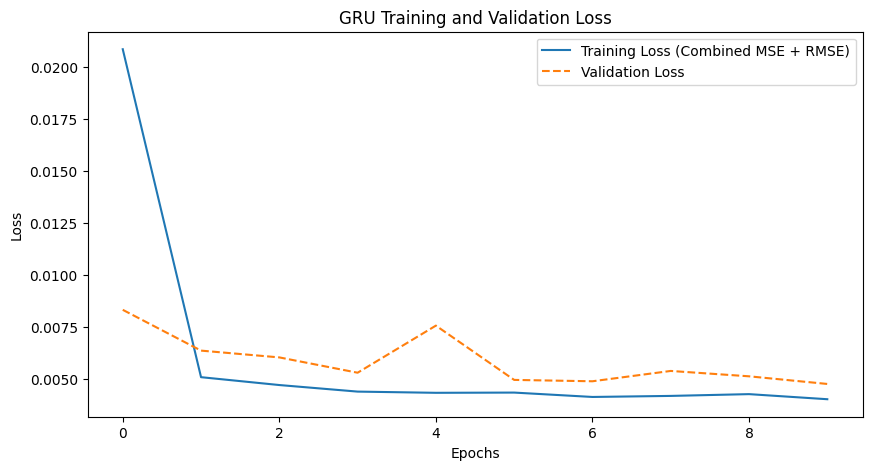

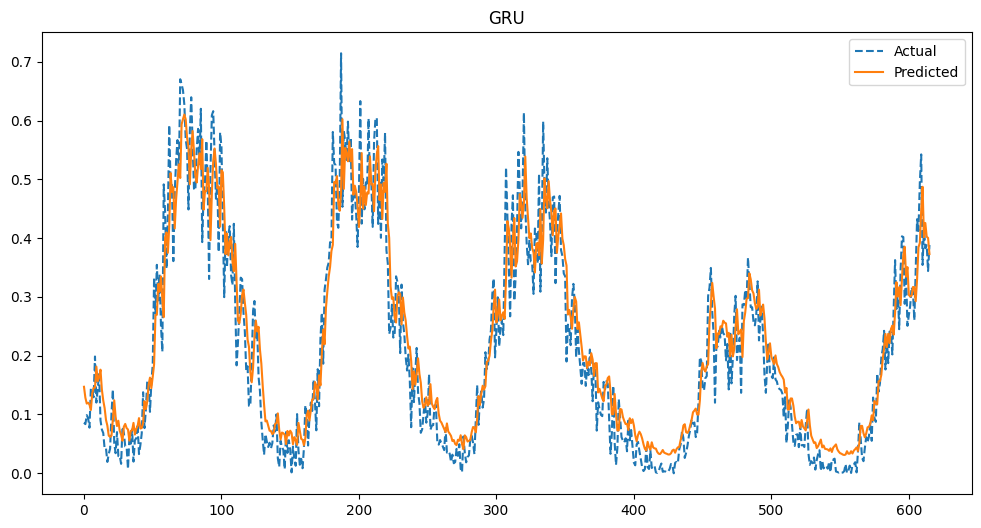

In [5]:
model = GRUModel(input_dim=df.shape[1], hidden_dim=48, output_dim=df.shape[1])
train_losses, val_losses, time_gru = train_model(model, train_loader, val_loader, epochs=10)
y_pred, y_true, inf_time, rmse, r2 = evaluate(model, test_loader)
plot_loss(train_losses, val_losses, "GRU")
plot_results(y_true, y_pred, "GRU")

In [15]:
mamba_model = MambaModel(input_dim=df.shape[1], hidden_dim=64, output_dim=df.shape[1])
train_losses, val_losses, time_mamba = train_model(mamba_model, train_loader, val_loader, epochs=10)
y_pred, y_true, inf_time, rmse, r2 = evaluate(mamba_model, test_loader)
plot_loss(train_losses, val_losses, "Mamba")
plot_results(y_true, y_pred, "Mamba Prediction")

RuntimeError: Expected u.is_cuda() to be true, but got false.  (Could this error message be improved?  If so, please report an enhancement request to PyTorch.)